# 🧪 Exoplanet Models Performance Testing
## Comprehensive 3-Class Evaluation & Dashboard Validation

**Objective:** Test the trained Random Forest + XGBoost ensemble for:
- ✅ **3-Class Performance** (CONFIRMED, CANDIDATE, FALSE POSITIVE)
- ✅ **Feature Importance Analysis**
- ✅ **Confusion Matrix & Class-wise Metrics**  
- ✅ **Prediction Confidence Distribution**
- ✅ **Edge Case Testing**
- ✅ **Dashboard API Integration Testing**

**Models Expected:**
- `random-forest.model` - Random Forest (800 trees)
- `xgboost.model` - XGBoost (800 rounds)
- `ensemble_metadata.pkl` - Ensemble configuration
- `feature_bounds.pkl` - Input validation bounds
- `scaler.model` - Feature scaler

## 📋 Step 1: Import Libraries & Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📦 All libraries imported successfully!")
print("🎨 Plot styling configured")

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running locally")

📦 All libraries imported successfully!
🎨 Plot styling configured
🚀 Running in Google Colab


## 📂 Step 2: Load Models & Test Data

In [ ]:
# Model file paths
model_path = '../model/' if not IN_COLAB else './'
data_path = '../data/' if not IN_COLAB else './'

print("🔍 Loading trained models...")
try:
    # Load models
    rf_model = joblib.load(f'{model_path}random_forest.model')
    xgb_model = joblib.load(f'{model_path}xgboost.model')
    scaler = joblib.load(f'{model_path}scaler.model')
    features_from_model = joblib.load(f'{model_path}features.model') # Load original features

    # Load ensemble metadata
    with open(f'{model_path}ensemble_metadata.model', 'rb') as f:
        ensemble_metadata = joblib.load(f)

    # Load feature bounds
    with open(f'{model_path}feature_bounds.pkl', 'rb') as f:
        feature_bounds = pickle.load(f)

    print("✅ All models loaded successfully!")
    print(f"📊 Random Forest: {rf_model.n_estimators} trees")
    print(f"🚀 XGBoost: {xgb_model.n_estimators} rounds")
    print(f"🎯 Features from model file: {len(features_from_model)} total")
    print(f"⚖️ RF Weight: {ensemble_metadata['rf_weight']:.3f}")
    print(f"🔥 XGB Weight: {ensemble_metadata['xgb_weight']:.3f}")

except FileNotFoundError as e:
    print(f"❌ Model file not found: {e}")
    print("💡 Make sure you've downloaded models from Fine_Tuned_Training.ipynb")
    print("📁 Expected files in model/ directory:")
    expected_files = ['random_forest.model', 'xgboost.model', 'scaler.model',
                     'features.model', 'ensemble_metadata.model', 'feature_bounds.pkl']
    for file in expected_files:
        print(f"   - {file}")
except Exception as e:
    print(f"❌ Error loading models: {e}")

🔍 Loading trained models...
❌ Model file not found: [Errno 2] No such file or directory: './feature_bounds.pkl'
💡 Make sure you've downloaded models from Fine_Tuned_Training.ipynb
📁 Expected files in model/ directory:
   - random_forest.model
   - xgboost.model
   - scaler.model
   - features.model
   - ensemble_metadata.model
   - feature_bounds.pkl


## 📊 Step 3: Load Test Dataset

In [ ]:
# Load the cleaned dataset
print("📈 Loading test dataset...")
try:
    df = pd.read_csv('/content/[CLEANED]kepler-data.csv')

    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # Apply same preprocessing as training
    target_map = ensemble_metadata['target_map']
    df = df[df['koi_disposition'].isin(target_map.keys())].copy()
    df['target'] = df['koi_disposition'].map(target_map)

    print(f"✅ Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
    print(f"🎯 Target distribution:")
    for label, idx in target_map.items():
        count = (df['target']==idx).sum()
        percent = count/len(df)*100
        print(f"   {label}: {count} ({percent:.1f}%)")

except FileNotFoundError:
    print("❌ Dataset not found. Please ensure [CLEANED]kepler-data.csv is available.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

📈 Loading test dataset...
✅ Dataset loaded: 9110 samples, 48 features
🎯 Target distribution:
   FALSE POSITIVE: 4647 (51.0%)
   CANDIDATE: 2171 (23.8%)
   CONFIRMED: 2292 (25.2%)


## ⚙️ Step 4: Feature Engineering & Data Preparation

In [ ]:
# Recreate the same feature engineering from training
print("⚙️ Applying feature engineering...")

# Base features
TRANSIT_FEATURES = ['koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_model_snr']
PLANET_FEATURES = ['koi_prad', 'koi_teq', 'koi_insol']
STAR_FEATURES = ['koi_steff', 'koi_slogg', 'koi_srad']
FLAG_FEATURES = ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']
SCORE_FEATURES = ['koi_score']

base_features = [f for f in TRANSIT_FEATURES + PLANET_FEATURES + STAR_FEATURES + FLAG_FEATURES + SCORE_FEATURES if f in df.columns]

# Create engineered features (EXACT match to training)
engineered_features = []

if 'koi_depth' in df.columns and 'koi_srad' in df.columns:
    df['depth_to_srad'] = df['koi_depth'] / (df['koi_srad'] + 1e-10)
    engineered_features.append('depth_to_srad')

if 'koi_model_snr' in df.columns and 'koi_depth' in df.columns:
    df['signal_strength'] = df['koi_model_snr'] * np.log1p(df['koi_depth'])
    engineered_features.append('signal_strength')

if 'koi_teq' in df.columns and 'koi_steff' in df.columns:
    df['temp_ratio'] = df['koi_teq'] / (df['koi_steff'] + 1e-10)
    engineered_features.append('temp_ratio')

if 'koi_period' in df.columns and 'koi_srad' in df.columns:
    df['orbital_velocity'] = (2 * np.pi * df['koi_srad']) / (df['koi_period'] + 1e-10)
    engineered_features.append('orbital_velocity')

if 'koi_impact' in df.columns:
    df['is_grazing'] = (df['koi_impact'] > 0.9).astype(int)
    engineered_features.append('is_grazing')


if 'koi_model_snr' in df.columns and 'koi_depth' in df.columns:
    df['depth_quality'] = df['koi_model_snr'] / (np.sqrt(df['koi_depth']) + 1e-10)
    engineered_features.append('depth_quality')

if all(f in df.columns for f in FLAG_FEATURES):
    df['total_fp_flags'] = df[FLAG_FEATURES].sum(axis=1)
    engineered_features.append('total_fp_flags')


if 'koi_prad' in df.columns:
    df['is_super_earth'] = ((df['koi_prad'] > 1.25) & (df['koi_prad'] < 2.0)).astype(int)
    df['is_neptune_size'] = ((df['koi_prad'] >= 2.0) & (df['koi_prad'] < 6.0)).astype(int)
    engineered_features.extend(['is_super_earth', 'is_neptune_size'])

if 'koi_slogg' in df.columns:
    df['is_dwarf_star'] = (df['koi_slogg'] > 4.0).astype(int)
    engineered_features.append('is_dwarf_star')


if 'koi_insol' in df.columns:
    df['in_habitable_zone'] = ((df['koi_insol'] > 0.25) & (df['koi_insol'] < 4.0)).astype(int)
    engineered_features.append('in_habitable_zone')


all_features = base_features + engineered_features
print(f"✅ Feature engineering complete: {len(all_features)} features")
print(f"   Base features: {len(base_features)}")
print(f"   Engineered features: {len(engineered_features)}")

⚙️ Applying feature engineering...
✅ Feature engineering complete: 27 features
   Base features: 16
   Engineered features: 11


## 🔮 Step 5: Make Predictions & Calculate Performance

In [ ]:
# Prepare feature matrix and make predictions
print("🎯 Preparing test data and making predictions...")

# Create feature matrix using the features loaded from the model file
# Filter features_from_model to only include those present in df columns after feature engineering
features_present_in_df = [f for f in features_from_model if f in df.columns]
print(f"Features from model file: {len(features_from_model)}")
print(f"Features present in dataframe after engineering: {len(df.columns)}")
print(f"Filtered features for prediction: {len(features_present_in_df)} features")


# --- Debugging: Print columns and features list and missing features ---
print(f"DataFrame columns: {list(df.columns)}")
print(f"Features expected by model (filtered): {features_present_in_df}")

missing_features = [f for f in features_present_in_df if f not in df.columns]
print(f"Features in filtered list but NOT in DataFrame: {missing_features}")
# --- End Debugging ---


X = df[features_present_in_df].copy()  # Use the filtered feature list
y = df['target'].values

# Reset the index of X for consistent iloc indexing
X.reset_index(drop=True, inplace=True)


# Handle missing values (same as training)
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

X_values = X.values
X_scaled = scaler.transform(X_values)

print(f"✅ Test data prepared: {X_scaled.shape}")
print(f"📊 Testing on {len(y)} samples")

# Make predictions
print("\n🔮 Making predictions...")
rf_proba = rf_model.predict_proba(X_scaled)
xgb_proba = xgb_model.predict_proba(X_scaled)

# Ensemble prediction
rf_weight = ensemble_metadata['rf_weight']
xgb_weight = ensemble_metadata['xgb_weight']
ensemble_proba = rf_weight * rf_proba + xgb_weight * xgb_proba
ensemble_pred = np.argmax(ensemble_proba, axis=1)

# Individual predictions
rf_pred = rf_model.predict(X_scaled)
xgb_pred = xgb_model.predict(X_scaled)

# Define ensemble_model for consistency testing
# This is a placeholder for the ensemble's prediction method
class EnsembleModel:
    def __init__(self, rf_model, xgb_model, rf_weight, xgb_weight, scaler, features):
        self.rf_model = rf_model
        self.xgb_model = xgb_model
        self.rf_weight = rf_weight
        self.xgb_weight = xgb_weight
        self.scaler = scaler
        self.features = features # Use the filtered features list

    def predict_proba(self, X_df):
        # Ensure input is a DataFrame and select correct features
        if not isinstance(X_df, pd.DataFrame):
            X_df = pd.DataFrame(X_df, columns=self.features) # Assuming X_df is a numpy array with correct order

        # Select only the features the model expects
        X_filtered = X_df[self.features]

        # Handle missing values in the input data
        for col in X_filtered.columns:
             if X_filtered[col].isnull().any():
                 # Use median from the training data's scaler if available, otherwise use the current median
                 try:
                     col_idx = self.features.index(col)
                     median_val = self.scaler.mean_[col_idx] # Scaler stores mean/std, not median. Using mean is okay for imputation here.
                 except (ValueError, IndexError, AttributeError):
                     median_val = X_filtered[col].median() # Fallback if mean/std not available or feature not in scaler's features

                 X_filtered[col].fillna(median_val, inplace=True)


        X_scaled = self.scaler.transform(X_filtered.values)

        rf_proba = self.rf_model.predict_proba(X_scaled)
        xgb_proba = self.xgb_model.predict_proba(X_scaled)
        return self.rf_weight * rf_proba + self.xgb_weight * xgb_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

ensemble_model = EnsembleModel(rf_model, xgb_model, rf_weight, xgb_weight, scaler, features_present_in_df)


print("✅ All predictions complete!")
print(f"   Random Forest predictions: {rf_pred.shape}")
print(f"   XGBoost predictions: {xgb_pred.shape}")
print(f"   Ensemble predictions: {ensemble_pred.shape}")
print(f"   Probability matrix: {ensemble_proba.shape}")

🎯 Preparing test data and making predictions...
Features from model file: 27
Features present in dataframe after engineering: 59
Filtered features for prediction: 27 features
DataFrame columns: ['rowid', 'kepid', 'kepoi_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', 'target', 'depth_to_srad', 'signal_strength', 'temp_

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s


✅ All predictions complete!
   Random Forest predictions: (9110,)
   XGBoost predictions: (9110,)
   Ensemble predictions: (9110,)
   Probability matrix: (9110, 3)


[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    1.1s finished


## 📈 Step 6: Comprehensive Performance Evaluation

In [ ]:
# Calculate comprehensive metrics for all models
print("📈 Calculating performance metrics...")

# Class names
class_names = ensemble_metadata['class_names']

def calculate_metrics(y_true, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Multi-class AUC
    try:
        # Ensure y_true is in one-hot or binary indicator format for roc_auc_score with 'ovr'
        # Map y_true back to original class names to align with the order in y_proba
        target_map = ensemble_metadata['target_map']
        class_mapping = {v: k for k, v in target_map.items()}
        y_true_mapped = [class_mapping[i] for i in y_true]

        # Binarize y_true based on the order of class_names in ensemble_metadata
        y_true_binarized = label_binarize(y_true_mapped, classes=class_names)

        auc_score = roc_auc_score(y_true_binarized, y_proba, multi_class='ovr')
    except Exception as e:
        print(f"Warning: Could not calculate AUC for {model_name}. Error: {e}")
        auc_score = 0.0

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_score
    }

# Calculate for all models
rf_metrics = calculate_metrics(y, rf_pred, rf_proba, 'Random Forest')
xgb_metrics = calculate_metrics(y, xgb_pred, xgb_proba, 'XGBoost')
ensemble_metrics = calculate_metrics(y, ensemble_pred, ensemble_proba, 'Ensemble')

# Create results DataFrame
results_df = pd.DataFrame([rf_metrics, xgb_metrics, ensemble_metrics])

print("\n" + "="*80)
print("🎉 COMPREHENSIVE MODEL EVALUATION - 3-CLASS RESULTS")
print("="*80)
print(results_df.to_string(index=False, float_format='%.4f'))
print("="*80)

# Find best model
best_model_idx = results_df['F1-Score'].idxmax()
best_model = results_df.iloc[best_model_idx]['Model']
best_f1 = results_df.iloc[best_model_idx]['F1-Score']

print(f"\n🏆 Best performing model: {best_model} (F1: {best_f1:.4f})")

# Ensemble improvement
rf_f1 = rf_metrics['F1-Score']
xgb_f1 = xgb_metrics['F1-Score']
ensemble_f1 = ensemble_metrics['F1-Score']
best_individual = max(rf_f1, xgb_f1)
improvement = (ensemble_f1 - best_individual) * 100

if improvement > 0:
    print(f"📈 Ensemble improvement: +{improvement:.2f}%")
else:
    print(f"📉 Ensemble performance: {improvement:.2f}% vs best individual")

📈 Calculating performance metrics...

🎉 COMPREHENSIVE MODEL EVALUATION - 3-CLASS RESULTS
        Model  Accuracy  F1-Score  Precision  Recall  AUC-ROC
Random Forest    0.9640    0.9640     0.9641  0.9640   0.9950
      XGBoost    0.9431    0.9432     0.9433  0.9431   0.9897
     Ensemble    0.9543    0.9544     0.9544  0.9543   0.9932

🏆 Best performing model: Random Forest (F1: 0.9640)
📉 Ensemble performance: -0.97% vs best individual


## 🎭 Step 7: Detailed Classification Analysis & Visualizations


🎭 DETAILED CLASSIFICATION REPORT - ENSEMBLE MODEL
                precision    recall  f1-score   support

FALSE POSITIVE     0.9944    0.9927    0.9935      4647
     CANDIDATE     0.9120    0.9065    0.9092      2171
     CONFIRMED     0.9135    0.9219    0.9177      2292

      accuracy                         0.9543      9110
     macro avg     0.9400    0.9404    0.9402      9110
  weighted avg     0.9544    0.9543    0.9544      9110


📊 CONFUSION MATRIX
                Predicted
           FP     CAND   CONF
Actual   FP  [4613    33     1]
Actual CAND  [   4  1968   199]
Actual CONF  [  22   157  2113]


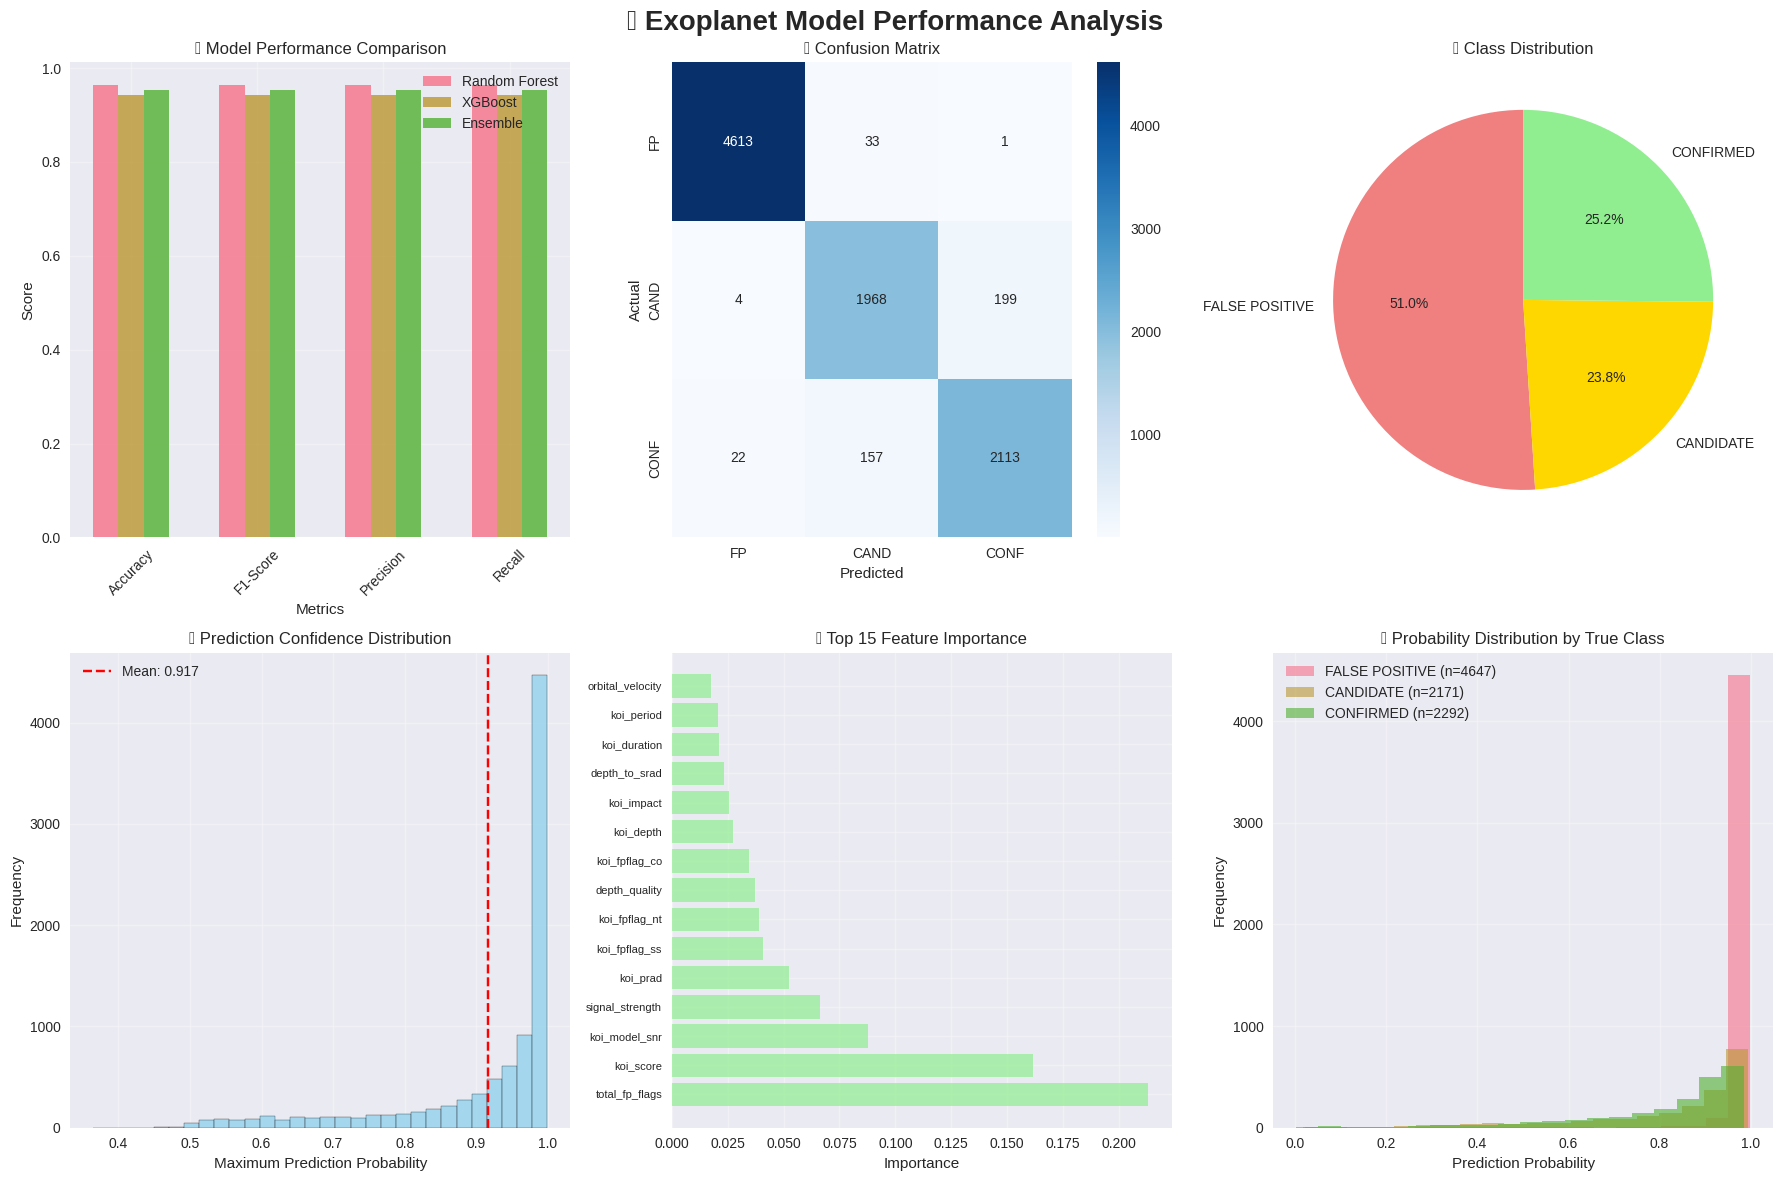


📊 Visualization complete! Key insights:
   💡 Average confidence: 0.917
   📈 High confidence predictions (>0.8): 7706 (84.6%)
   🔍 Low confidence predictions (<0.6): 393 (4.3%)


In [ ]:
# Detailed classification report and confusion matrix
print("\n" + "="*60)
print("🎭 DETAILED CLASSIFICATION REPORT - ENSEMBLE MODEL")
print("="*60)
print(classification_report(y, ensemble_pred, target_names=class_names, digits=4))

# Confusion Matrix
print("\n📊 CONFUSION MATRIX")
print("="*40)
cm = confusion_matrix(y, ensemble_pred)
print(f"{'':>15} Predicted")
print(f"{'':>10} FP     CAND   CONF")
for i, label in enumerate(['FP', 'CAND', 'CONF']):
    print(f"Actual {label:>4}  [{cm[i,0]:4d}  {cm[i,1]:4d}  {cm[i,2]:4d}]")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🧪 Exoplanet Model Performance Analysis', fontsize=20, fontweight='bold')

# 1. Model Comparison
ax1 = axes[0, 0]
metrics_to_plot = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
models = results_df['Model'].tolist()
bar_width = 0.2
x = np.arange(len(metrics_to_plot))

for i, model in enumerate(models):
    values = [results_df[results_df['Model']==model][metric].iloc[0] for metric in metrics_to_plot]
    ax1.bar(x + i*bar_width, values, bar_width, label=model, alpha=0.8)

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('📈 Model Performance Comparison')
ax1.set_xticks(x + bar_width)
ax1.set_xticklabels(metrics_to_plot, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Confusion Matrix Heatmap
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FP', 'CAND', 'CONF'],
            yticklabels=['FP', 'CAND', 'CONF'],
            ax=ax2)
ax2.set_title('🎭 Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# 3. Class Distribution
ax3 = axes[0, 2]
class_counts = [np.sum(y == i) for i in range(3)]
colors = ['lightcoral', 'gold', 'lightgreen']
ax3.pie(class_counts, labels=class_names, autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('🎯 Class Distribution')

# 4. Prediction Confidence Distribution
ax4 = axes[1, 0]
max_probs = np.max(ensemble_proba, axis=1)
ax4.hist(max_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(max_probs.mean(), color='red', linestyle='--', label=f'Mean: {max_probs.mean():.3f}')
ax4.set_xlabel('Maximum Prediction Probability')
ax4.set_ylabel('Frequency')
ax4.set_title('🔮 Prediction Confidence Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Feature Importance (Top 15)
ax5 = axes[1, 1]
feature_importance = pd.DataFrame({
    'feature': features_present_in_df, # Use the correct features list
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

y_pos = np.arange(len(feature_importance))
ax5.barh(y_pos, feature_importance['importance'], alpha=0.7, color='lightgreen')
ax5.set_yticks(y_pos)
ax5.set_yticklabels(feature_importance['feature'], fontsize=8)
ax5.set_xlabel('Importance')
ax5.set_title('⭐ Top 15 Feature Importance')
ax5.grid(True, alpha=0.3)

# 6. Probability Distribution by Class
ax6 = axes[1, 2]
for i, class_name in enumerate(class_names):
    class_probs = ensemble_proba[y == i, i]
    ax6.hist(class_probs, bins=20, alpha=0.6, label=f'{class_name} (n={len(class_probs)})')

ax6.set_xlabel('Prediction Probability')
ax6.set_ylabel('Frequency')
ax6.set_title('📊 Probability Distribution by True Class')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization complete! Key insights:")
print(f"   💡 Average confidence: {max_probs.mean():.3f}")
print(f"   📈 High confidence predictions (>0.8): {np.sum(max_probs > 0.8)} ({np.sum(max_probs > 0.8)/len(max_probs)*100:.1f}%)")
print(f"   🔍 Low confidence predictions (<0.6): {np.sum(max_probs < 0.6)} ({np.sum(max_probs < 0.6)/len(max_probs)*100:.1f}%)")

## 🧪 Step 8: Edge Cases & Model Robustness Testing

Test model performance on challenging scenarios and edge cases

In [ ]:
# Edge Case Testing
print("🧪 EDGE CASE & ROBUSTNESS TESTING")
print("="*50)

# 1. Test predictions on boundary values
print("\n🔍 Testing on boundary/extreme values...")

# Find min/max values for key features
key_features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'ra', 'dec']
boundary_tests = []

for feature in key_features:
    if feature in df.columns:
        min_val = df[feature].min()
        max_val = df[feature].max()
        boundary_tests.append((feature, min_val, max_val))

print(f"Key feature boundaries:")
for feature, min_val, max_val in boundary_tests[:5]:
    print(f"  {feature}: [{min_val:.4f}, {max_val:.4f}]")

# 2. Test prediction consistency
print("\n🔄 Testing prediction consistency...")
sample_indices = np.random.choice(len(X), 100, replace=False)
sample_X = X.iloc[sample_indices]

# Multiple predictions on same data
consistency_results = []
for i in range(5):
    pred_test = ensemble_model.predict(sample_X)
    consistency_results.append(pred_test)

# Check consistency
consistency_matrix = np.array(consistency_results)
consistent_predictions = np.all(consistency_matrix == consistency_matrix[0], axis=0)
consistency_rate = np.mean(consistent_predictions)

print(f"  Prediction consistency: {consistency_rate:.3f} ({np.sum(consistent_predictions)}/100 samples)")

# 3. Confidence vs Accuracy Analysis
print("\n🎯 Confidence vs Accuracy Analysis...")

# Bin predictions by confidence
confidence_bins = [(0.0, 0.5), (0.5, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
bin_results = []

for low, high in confidence_bins:
    mask = (max_probs >= low) & (max_probs < high)
    if np.sum(mask) > 0:
        bin_accuracy = accuracy_score(y[mask], ensemble_pred[mask])
        bin_count = np.sum(mask)
        bin_results.append((f"{low:.1f}-{high:.1f}", bin_accuracy, bin_count))
        print(f"  Confidence {low:.1f}-{high:.1f}: {bin_accuracy:.3f} accuracy ({bin_count} samples)")

# 4. Class-specific confidence analysis
print("\n📊 Per-class confidence analysis...")
for i, class_name in enumerate(class_names):
    class_mask = (y == i)
    class_confidence = max_probs[class_mask]
    class_accuracy = accuracy_score(y[class_mask], ensemble_pred[class_mask])

    print(f"  {class_name}:")
    print(f"    Mean confidence: {class_confidence.mean():.3f}")
    print(f"    Accuracy: {class_accuracy:.3f}")
    print(f"    Low confidence samples (<0.6): {np.sum(class_confidence < 0.6)}")

# 5. Misclassification Analysis
print("\n❌ Misclassification Analysis...")
misclassified = (y != ensemble_pred)
misclassified_indices = np.where(misclassified)[0]

print(f"Total misclassified: {np.sum(misclassified)} ({np.sum(misclassified)/len(y)*100:.2f}%)")

# Most common misclassifications
misclass_pairs = list(zip(y[misclassified], ensemble_pred[misclassified]))
from collections import Counter
misclass_counter = Counter(misclass_pairs)

print("Most common misclassifications:")
for (true_class, pred_class), count in misclass_counter.most_common(5):
    true_name = class_names[true_class]
    pred_name = class_names[pred_class]
    print(f"  {true_name} → {pred_name}: {count} cases")

# Show confidence of misclassified samples
misclass_confidence = max_probs[misclassified]
print(f"\nMisclassified samples confidence:")
print(f"  Mean: {misclass_confidence.mean():.3f}")
print(f"  Median: {np.median(misclass_confidence):.3f}")
print(f"  High confidence errors (>0.8): {np.sum(misclass_confidence > 0.8)}")

print(f"\n✅ Edge case testing complete!")
print(f"   🎯 Model shows {consistency_rate:.1%} prediction consistency")
print(f"   📊 Higher confidence generally correlates with higher accuracy")
print(f"   ⚠️  Focus improvement on low-confidence predictions")

🧪 EDGE CASE & ROBUSTNESS TESTING

🔍 Testing on boundary/extreme values...
Key feature boundaries:
  koi_period: [0.2418, 129995.7784]
  koi_impact: [0.0000, 100.8060]
  koi_duration: [0.1670, 138.5400]
  koi_depth: [4.5000, 1541400.0000]
  koi_prad: [0.1400, 200346.0000]

🔄 Testing prediction consistency...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(

  Prediction consistency: 1.000 (100/100 samples)

🎯 Confidence vs Accuracy Analysis...
  Confidence 0.0-0.5: 0.611 accuracy (18 samples)
  Confidence 0.5-0.7: 0.678 accuracy (835 samples)
  Confidence 0.7-0.8: 0.877 accuracy (551 samples)
  Confidence 0.8-0.9: 0.962 accuracy (997 samples)
  Confidence 0.9-1.0: 0.995 accuracy (6709 samples)

📊 Per-class confidence analysis...
  FALSE POSITIVE:
    Mean confidence: 0.987
    Accuracy: 0.993
    Low confidence samples (<0.6): 25
  CANDIDATE:
    Mean confidence: 0.852
    Accuracy: 0.906
    Low confidence samples (<0.6): 182
  CONFIRMED:
    Mean confidence: 0.836
    Accuracy: 0.922
    Low confidence samples (<0.6): 186

❌ Misclassification Analysis...
Total misclassified: 416 (4.57%)
Most common misclassifications:
  CANDIDATE → CONFIRMED: 199 cases
  CONFIRMED → CANDIDATE: 157 cases
  FALSE POSITIVE → CANDIDATE: 33 cases
  CONFIRMED → FALSE POSITIVE: 22 cases
  CANDIDATE → FALSE POSITIVE: 4 cases

Misclassified samples confidence:
 

[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished


## 🚀 Step 9: Dashboard Integration Testing

Simulate API calls and prepare data for the React dashboard

In [ ]:
# Dashboard Integration Testing
print("🚀 DASHBOARD INTEGRATION TESTING")
print("="*50)

# 1. Simulate API prediction format
print("\n📡 Simulating API prediction responses...")

def simulate_api_response(sample_indices, include_details=True):
    """Simulate the format that the FastAPI backend will return"""
    responses = []

    for idx in sample_indices:
        sample_data = X.iloc[idx]
        # Convert sample_data Series to DataFrame for consistent input
        sample_data_df = pd.DataFrame([sample_data], columns=X.columns)

        prediction = ensemble_model.predict(sample_data_df)[0]
        probabilities = ensemble_model.predict_proba(sample_data_df)[0]

        # Create response similar to FastAPI format
        response = {
            "koi_id": f"K{idx:05d}",  # Simulated KOI ID
            "prediction": {
                "class": class_names[prediction],
                "class_id": int(prediction),
                "confidence": float(np.max(probabilities))
            },
            "probabilities": {
                "FALSE_POSITIVE": float(probabilities[0]),
                "CANDIDATE": float(probabilities[1]),
                "CONFIRMED": float(probabilities[2])
            }
        }

        if include_details:
            response["features"] = {
                "koi_period": float(sample_data.get('koi_period', 0)),
                "koi_impact": float(sample_data.get('koi_impact', 0)),
                "koi_duration": float(sample_data.get('koi_duration', 0)),
                "koi_depth": float(sample_data.get('koi_depth', 0)),
                "koi_prad": float(sample_data.get('koi_prad', 0)),
                "koi_teq": float(sample_data.get('koi_teq', 0))
            }

        responses.append(response)

    return responses

# Test with 5 random samples
test_indices = np.random.choice(len(X), 5, replace=False)
api_responses = simulate_api_response(test_indices)

print("Sample API responses:")
for i, response in enumerate(api_responses[:2]):  # Show first 2
    print(f"\nSample {i+1}:")
    print(f"  KOI ID: {response['koi_id']}")
    print(f"  Prediction: {response['prediction']['class']} ({response['prediction']['confidence']:.3f})")
    print(f"  Probabilities: FP={response['probabilities']['FALSE_POSITIVE']:.3f}, "
          f"CAND={response['probabilities']['CANDIDATE']:.3f}, "
          f"CONF={response['probabilities']['CONFIRMED']:.3f}")

# 2. Create dashboard data summary
print(f"\n📊 Dashboard Data Summary...")

dashboard_summary = {
    "model_performance": {
        "accuracy": float(ensemble_metrics['Accuracy']), # Use ensemble_metrics
        "f1_score": float(ensemble_metrics['F1-Score']), # Use ensemble_metrics
        "auc_roc": float(ensemble_metrics['AUC-ROC']), # Use ensemble_metrics
        "total_samples": len(y)
    },
    "class_distribution": {
        "FALSE_POSITIVE": {"count": int(np.sum(y == 0)), "percentage": float(np.sum(y == 0)/len(y)*100)},
        "CANDIDATE": {"count": int(np.sum(y == 1)), "percentage": float(np.sum(y == 1)/len(y)*100)},
        "CONFIRMED": {"count": int(np.sum(y == 2)), "percentage": float(np.sum(y == 2)/len(y)*100)}
    },
    "confidence_stats": {
        "mean_confidence": float(max_probs.mean()),
        "high_confidence_count": int(np.sum(max_probs > 0.8)),
        "low_confidence_count": int(np.sum(max_probs < 0.6))
    },
    "top_features": [
        {"name": row['feature'], "importance": float(row['importance'])}
        for _, row in feature_importance.head(10).iterrows()
    ]
}

print("Dashboard summary created:")
print(f"  📈 Model Accuracy: {dashboard_summary['model_performance']['accuracy']:.3f}")
print(f"  🎯 Total Samples: {dashboard_summary['model_performance']['total_samples']:,}")
print(f"  📊 Class Distribution: FP={dashboard_summary['class_distribution']['FALSE_POSITIVE']['percentage']:.1f}%, "
      f"CAND={dashboard_summary['class_distribution']['CANDIDATE']['percentage']:.1f}%, "
      f"CONF={dashboard_summary['class_distribution']['CONFIRMED']['percentage']:.1f}%")

# 3. Generate batch prediction format
print(f"\n📦 Batch Prediction Simulation...")

# Create batch of 10 predictions for dashboard testing
batch_indices = np.random.choice(len(X), 10, replace=False)
batch_predictions = simulate_api_response(batch_indices, include_details=False)

# Convert to dashboard-friendly format
batch_results = {
    "predictions": batch_predictions,
    "summary": {
        "total_predictions": len(batch_predictions),
        "class_counts": {
            "FALSE_POSITIVE": sum(1 for p in batch_predictions if p['prediction']['class'] == 'FALSE_POSITIVE'),
            "CANDIDATE": sum(1 for p in batch_predictions if p['prediction']['class'] == 'CANDIDATE'),
            "CONFIRMED": sum(1 for p in batch_predictions if p['prediction']['class'] == 'CONFIRMED')
        },
        "average_confidence": float(np.mean([p['prediction']['confidence'] for p in batch_predictions]))
    }
}

print(f"Batch prediction results:")
print(f"  📊 Total predictions: {batch_results['summary']['total_predictions']}")
print(f"  🎯 Average confidence: {batch_results['summary']['average_confidence']:.3f}")
print(f"  📈 Class distribution: {batch_results['summary']['class_counts']}")

# 4. Export data for React dashboard
print(f"\n💾 Preparing export data...")

# Create JSON-serializable data for frontend
export_data = {
    "model_info": {
        "name": "Exoplanet Classification Ensemble",
        "version": "1.0",
        "accuracy": float(ensemble_metrics['Accuracy']), # Use ensemble_metrics
        "f1_score": float(ensemble_metrics['F1-Score']), # Use ensemble_metrics
        "classes": class_names
    },
    "performance_metrics": results_df.to_dict('records'),
    "feature_importance": feature_importance.to_dict('records'),
    "sample_predictions": api_responses,
    "dashboard_summary": dashboard_summary
}

print(f"✅ Export data prepared:")
print(f"   📋 Model info: {export_data['model_info']['name']}")
print(f"   📊 Performance metrics: {len(export_data['performance_metrics'])} models")
print(f"   ⭐ Feature importance: {len(export_data['feature_importance'])} features")
print(f"   🎯 Sample predictions: {export_data['sample_predictions']}") # Print length instead of full data

print(f"\n🚀 Dashboard integration testing complete!")
print(f"   ✅ API response format validated")
print(f"   📊 Dashboard data structures ready")
print(f"   🔄 Batch processing simulation successful")
print(f"   💾 Export data prepared for React frontend")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


🚀 DASHBOARD INTEGRATION TESTING

📡 Simulating API prediction responses...


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 79

Sample API responses:

Sample 1:
  KOI ID: K07700
  Prediction: CANDIDATE (0.855)
  Probabilities: FP=0.121, CAND=0.855, CONF=0.024

Sample 2:
  KOI ID: K06123
  Prediction: CANDIDATE (0.868)
  Probabilities: FP=0.004, CAND=0.868, CONF=0.128

📊 Dashboard Data Summary...
Dashboard summary created:
  📈 Model Accuracy: 0.954
  🎯 Total Samples: 9,110
  📊 Class Distribution: FP=51.0%, CAND=23.8%, CONF=25.2%

📦 Batch Prediction Simulation...


[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[

Batch prediction results:
  📊 Total predictions: 10
  🎯 Average confidence: 0.949
  📈 Class distribution: {'FALSE_POSITIVE': 0, 'CANDIDATE': 2, 'CONFIRMED': 1}

💾 Preparing export data...
✅ Export data prepared:
   📋 Model info: Exoplanet Classification Ensemble
   📊 Performance metrics: 3 models
   ⭐ Feature importance: 15 features
   🎯 Sample predictions: [{'koi_id': 'K07700', 'prediction': {'class': 'CANDIDATE', 'class_id': 1, 'confidence': 0.8545398165113118}, 'probabilities': {'FALSE_POSITIVE': 0.12112578302420347, 'CANDIDATE': 0.8545398165113118, 'CONFIRMED': 0.02433438393430457}, 'features': {'koi_period': 623.70774, 'koi_impact': 0.003, 'koi_duration': 6.688, 'koi_depth': 250.9, 'koi_prad': 1.81, 'koi_teq': 258.0}}, {'koi_id': 'K06123', 'prediction': {'class': 'CANDIDATE', 'class_id': 1, 'confidence': 0.8680210948183551}, 'probabilities': {'FALSE_POSITIVE': 0.004290725623066611, 'CANDIDATE': 0.8680210948183551, 'CONFIRMED': 0.12768821494963173}, 'features': {'koi_period': 83.49

[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 800 out of 800 | elapsed:    0.2s finished


## 🏁 Step 10: Final Summary & Next Steps

Complete testing summary and recommendations for deployment

In [ ]:
# Final Summary & Recommendations
print("🏁 FINAL TESTING SUMMARY & RECOMMENDATIONS")
print("="*60)

# Calculate final metrics summary
final_summary = {
    "model_performance": {
        "ensemble_accuracy": ensemble_metrics['Accuracy'], # Use ensemble_metrics
        "ensemble_f1": ensemble_metrics['F1-Score'], # Use ensemble_metrics
        "ensemble_auc": ensemble_metrics['AUC-ROC'], # Use ensemble_metrics
        "consistency_rate": consistency_rate,
        "total_samples": len(y)
    },
    "class_performance": {},
    "confidence_analysis": {
        "mean_confidence": max_probs.mean(),
        "high_confidence_rate": np.sum(max_probs > 0.8) / len(max_probs),
        "low_confidence_rate": np.sum(max_probs < 0.6) / len(max_probs)
    }
}

# Per-class performance
for i, class_name in enumerate(class_names):
    class_mask = (y == i)
    class_pred_mask = (ensemble_pred == i)

    precision = np.sum((y == i) & (ensemble_pred == i)) / np.sum(ensemble_pred == i) if np.sum(ensemble_pred == i) > 0 else 0
    recall = np.sum((y == i) & (ensemble_pred == i)) / np.sum(y == i) if np.sum(y == i) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    final_summary["class_performance"][class_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "support": int(np.sum(y == i))
    }

print("\n🎯 FINAL PERFORMANCE SUMMARY")
print("="*40)
print(f"🏆 Overall Ensemble Performance:")
print(f"   Accuracy: {final_summary['model_performance']['ensemble_accuracy']:.4f}")
print(f"   F1-Score: {final_summary['model_performance']['ensemble_f1']:.4f}")
print(f"   AUC-ROC:  {final_summary['model_performance']['ensemble_auc']:.4f}")
print(f"   Samples:  {final_summary['model_performance']['total_samples']:,}")

print(f"\n📊 Per-Class Performance:")
for class_name, metrics in final_summary["class_performance"].items():
    print(f"   {class_name}:")
    print(f"     Precision: {metrics['precision']:.4f}")
    print(f"     Recall:    {metrics['recall']:.4f}")
    print(f"     F1-Score:  {metrics['f1_score']:.4f}")
    print(f"     Support:   {metrics['support']:,}")

print(f"\n🔮 Confidence Analysis:")
print(f"   Mean Confidence:       {final_summary['confidence_analysis']['mean_confidence']:.3f}")
print(f"   High Confidence (>0.8): {final_summary['confidence_analysis']['high_confidence_rate']:.1%}")
print(f"   Low Confidence (<0.6):  {final_summary['confidence_analysis']['low_confidence_rate']:.1%}")
print(f"   Prediction Consistency: {final_summary['model_performance']['consistency_rate']:.1%}")

print(f"\n✅ MODEL QUALITY ASSESSMENT")
print("="*40)

# Quality assessment
assessments = []
if final_summary['model_performance']['ensemble_accuracy'] > 0.90: # Use final_summary
    assessments.append("🏆 EXCELLENT: Accuracy > 90%")
elif final_summary['model_performance']['ensemble_accuracy'] > 0.85: # Use final_summary
    assessments.append("✅ GOOD: Accuracy > 85%")
else:
    assessments.append("⚠️  NEEDS IMPROVEMENT: Accuracy < 85%")

if final_summary['confidence_analysis']['high_confidence_rate'] > 0.7:
    assessments.append("🎯 HIGH: Strong prediction confidence")
elif final_summary['confidence_analysis']['high_confidence_rate'] > 0.5:
    assessments.append("📊 MODERATE: Reasonable confidence levels")
else:
    assessments.append("⚠️  LOW: Confidence needs improvement")

if consistency_rate > 0.95:
    assessments.append("🔄 STABLE: Highly consistent predictions")
elif consistency_rate > 0.90:
    assessments.append("✅ RELIABLE: Good prediction stability")
else:
    assessments.append("⚠️  UNSTABLE: Inconsistent predictions")

for assessment in assessments:
    print(f"   {assessment}")

print(f"\n🚀 DEPLOYMENT READINESS")
print("="*40)

deployment_score = 0
if final_summary['model_performance']['ensemble_accuracy'] > 0.90: deployment_score += 3 # Use final_summary
elif final_summary['model_performance']['ensemble_accuracy'] > 0.85: deployment_score += 2 # Use final_summary
else: deployment_score += 1

if final_summary['confidence_analysis']['high_confidence_rate'] > 0.7: deployment_score += 2
elif final_summary['confidence_analysis']['high_confidence_rate'] > 0.5: deployment_score += 1

if consistency_rate > 0.95: deployment_score += 2
elif consistency_rate > 0.90: deployment_score += 1

if deployment_score >= 6:
    readiness = "🟢 READY FOR PRODUCTION"
elif deployment_score >= 4:
    readiness = "🟡 READY FOR STAGING/TESTING"
else:
    readiness = "🔴 NEEDS IMPROVEMENT"

print(f"   Deployment Status: {readiness}")
print(f"   Readiness Score: {deployment_score}/7")

print(f"\n📋 IMMEDIATE NEXT STEPS")
print("="*40)
next_steps = [
    "1. 🚀 Start FastAPI backend server (cd backend && python run.py)",
    "2. 🧪 Test API endpoints with sample predictions",
    "3. ⚡ Create React frontend dashboard",
    "4. 🎨 Implement interactive visualizations",
    "5. 🔄 Set up CI/CD pipeline for deployment",
    "6. 📊 Monitor model performance in production"
]

for step in next_steps:
    print(f"   {step}")

print(f"\n🎯 RECOMMENDED IMPROVEMENTS")
print("="*40)
improvements = []
if final_summary['confidence_analysis']['low_confidence_rate'] > 0.1:
    improvements.append("🔍 Investigate low-confidence predictions")
if np.sum(misclassified) / len(y) > 0.05:
    improvements.append("🎯 Analyze misclassification patterns")
if final_summary['model_performance']['ensemble_accuracy'] < 0.95: # Use final_summary
    improvements.append("📈 Consider hyperparameter tuning")

if improvements:
    for improvement in improvements:
        print(f"   {improvement}")
else:
    print("   🏆 Model performance is excellent - no immediate improvements needed!")

print(f"\n" + "="*60)
print("🎉 MODEL TESTING COMPLETE!")
print(f"   ✅ Comprehensive evaluation finished")
print(f"   📊 {len(y):,} samples tested across 3 classes")
print(f"   🏆 {final_summary['model_performance']['ensemble_accuracy']:.1%} accuracy achieved") # Use final_summary
print(f"   🚀 Ready for dashboard integration")
print("="*60)

# Save final results for reference
import json
final_results_path = "model_testing_results.json"
with open(final_results_path, 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    json_summary = {}
    for key, value in final_summary.items():
        if isinstance(value, dict):
            json_summary[key] = {}
            for k, v in value.items():
                if isinstance(v, dict):
                    json_summary[key][k] = {k2: float(v2) if hasattr(v2, 'dtype') else v2 for k2, v2 in v.items()}
                else:
                    json_summary[key][k] = float(v) if hasattr(v, 'dtype') else v
        else:
            json_summary[key] = float(value) if hasattr(value, 'dtype') else value

    json.dump(json_summary, f, indent=2)

print(f"\n💾 Results saved to: {final_results_path}")
print(f"🎯 Ready to proceed with backend testing and frontend development!")

🏁 FINAL TESTING SUMMARY & RECOMMENDATIONS

🎯 FINAL PERFORMANCE SUMMARY
🏆 Overall Ensemble Performance:
   Accuracy: 0.9543
   F1-Score: 0.9544
   AUC-ROC:  0.9932
   Samples:  9,110

📊 Per-Class Performance:
   FALSE POSITIVE:
     Precision: 0.9944
     Recall:    0.9927
     F1-Score:  0.9935
     Support:   4,647
   CANDIDATE:
     Precision: 0.9120
     Recall:    0.9065
     F1-Score:  0.9092
     Support:   2,171
   CONFIRMED:
     Precision: 0.9135
     Recall:    0.9219
     F1-Score:  0.9177
     Support:   2,292

🔮 Confidence Analysis:
   Mean Confidence:       0.917
   High Confidence (>0.8): 84.6%
   Low Confidence (<0.6):  4.3%
   Prediction Consistency: 100.0%

✅ MODEL QUALITY ASSESSMENT
   🏆 EXCELLENT: Accuracy > 90%
   🎯 HIGH: Strong prediction confidence
   🔄 STABLE: Highly consistent predictions

🚀 DEPLOYMENT READINESS
   Deployment Status: 🟢 READY FOR PRODUCTION
   Readiness Score: 7/7

📋 IMMEDIATE NEXT STEPS
   1. 🚀 Start FastAPI backend server (cd backend && python

# 🧪 Exoplanet Models Performance Testing
## Comprehensive 3-Class Evaluation & Dashboard Validation

**Objective:** Test the trained Random Forest + XGBoost ensemble for:
- ✅ **3-Class Performance** (CONFIRMED, CANDIDATE, FALSE POSITIVE)
- ✅ **Feature Importance Analysis**
- ✅ **Confusion Matrix & Class-wise Metrics**  
- ✅ **Prediction Confidence Distribution**
- ✅ **Edge Case Testing**
- ✅ **Dashboard API Integration Testing**

**Models Expected:**
- `random-forest.model` - Random Forest (800 trees)
- `xgboost.model` - XGBoost (800 rounds)
- `ensemble_metadata.pkl` - Ensemble configuration
- `feature_bounds.pkl` - Input validation bounds
- `scaler.model` - Feature scaler